In [6]:
import matplotlib.pyplot
import numpy
import scipy.stats

In [108]:
def gen_data(
    m: numpy.ndarray,
    c: numpy.ndarray,
    size: int
) -> tuple[scipy.stats._multivariate.multivariate_normal_gen, numpy.ndarray]:
    rv = scipy.stats.multivariate_normal(mean=m, cov=c)
    data = rv.rvs(size=size, random_state=None)

    return rv, data.T

def disc_fn(mu: numpy.ndarray, c: numpy.ndarray) -> tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]:
    mu = numpy.reshape(a=mu, newshape=(mu.shape[0], 1))
    W = -0.5*scipy.linalg.inv(a=c)
    w = scipy.linalg.inv(a=c)@mu
    b = -0.5*mu.T@scipy.linalg.inv(a=c)@mu-0.5*numpy.log(scipy.linalg.det(a=c))+numpy.log(0.5)

    return W, w, b

def plt_decision_boundary(
    rv0: scipy.stats._multivariate.multivariate_normal_gen,
    rv1: scipy.stats._multivariate.multivariate_normal_gen,
    mu0: numpy.ndarray,
    mu1: numpy.ndarray,
    data0: numpy.ndarray,
    data1: numpy.ndarray,
    marker_size: int,
    rad: int,
    num_pts: int,
    levels: int,
    disc_x: numpy.ndarray,
    disc_y: numpy.ndarray,
    label: str,
):
    fig, ax = matplotlib.pyplot.subplots(figsize=(8, 6))
    matplotlib.pyplot.rc(group="font", family="serif")
    matplotlib.pyplot.scatter(x=data0[0, :], y=data0[1, :], s=marker_size, c="cyan", marker='x')
    matplotlib.pyplot.scatter(x=data1[0, :], y=data1[1, :], s=marker_size, c="orange", marker='o')
    # matplotlib.pyplot.axis("equal")
    matplotlib.pyplot.xlabel(r"$x$")
    matplotlib.pyplot.ylabel(r"$y$")
    x, y = numpy.meshgrid(numpy.linspace(start=mu0[0]-rad, stop=mu0[0]+rad, num=num_pts),
                          numpy.linspace(start=mu0[1]-rad, stop=mu0[1]+rad, num=num_pts))
    grid = numpy.dstack(tup=(x, y))
    pdf_vals = rv0.pdf(x=grid)
    matplotlib.pyplot.contour(x, y, pdf_vals, levels=levels, colors="silver", alpha=0.5)
    x, y = numpy.meshgrid(numpy.linspace(start=mu1[0]-rad, stop=mu1[0]+rad, num=num_pts),
                          numpy.linspace(start=mu1[1]-rad, stop=mu1[1]+rad, num=num_pts))
    grid = numpy.dstack(tup=(x, y))
    pdf_vals = rv1.pdf(x=grid)
    matplotlib.pyplot.contour(x, y, pdf_vals, levels=levels, colors="silver", alpha=0.5)
    matplotlib.pyplot.plot(disc_x, disc_y, color="magenta", label=label)
    matplotlib.pyplot.legend()
    
    matplotlib.pyplot.show()

    return

### Problem 1 Discriminant functions

##### Problem 1 (a)

In [90]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)
mu1 = numpy.array(object=[4, 0], dtype=numpy.float32)
c1 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5  0. ]
 [-0.  -0.5]]
[[0.]
 [0.]]
[[-0.6931472]]

W1 w1 b1
[[-0.5  0. ]
 [-0.  -0.5]]
[[4.]
 [0.]]
[[-8.693148]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -0.6931472 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}-0.693148
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 4 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -8.693148 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}-8.693148
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.5x_{1}^{2}-0.693148 &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}-8.693148 \\
    4x_{0} &= 8 \\
    x_{0} &= 2
\end{align}

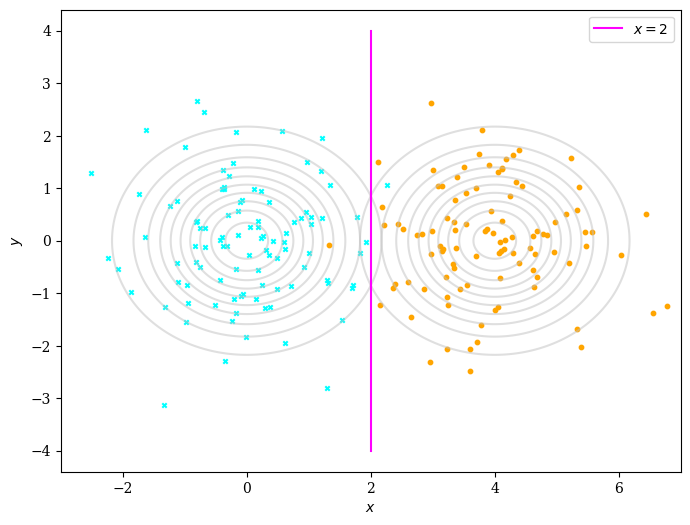

In [91]:
y = numpy.linspace(start=-4, stop=4, num=500)
x = numpy.full(shape=y.shape, fill_value=2)

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=2$"
)

##### Problem 1 (b)

In [94]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 2]], dtype=numpy.float32)
mu1 = numpy.array(object=[4, 3], dtype=numpy.float32)
c1 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5   0.  ]
 [-0.   -0.25]]
[[0.]
 [0.]]
[[-1.0397208]]

W1 w1 b1
[[-0.5  0. ]
 [-0.  -0.5]]
[[4.]
 [3.]]
[[-13.193148]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.25 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -1.0397208 \\
    &= -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 4 \\ 3\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -13.193148 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}+3x_{1}-13.193148
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208 &= -0.5x_{0}^{2}-0.5x_{1}^{2}+4x_{0}+3x_{1}-13.193148 \\
    0.25x_{1}^{2}-3x_{1}+12.1534272 &= 4x_{0} \\
    x_{0} &= \frac{0.25x_{1}^{2}-3x_{1}-12.1534272}{4}
\end{align}

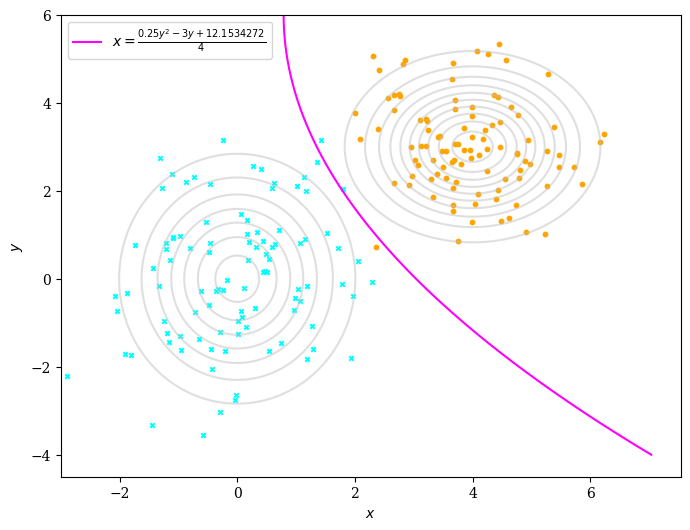

In [96]:
y = numpy.linspace(start=-4, stop=6, num=500)
x = (0.25*y**2-3*y+12.1534272)/4.0

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=\\frac{0.25y^{2}-3y+12.1534272}{4}$"
)

##### Problem 1 (c)

In [102]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 2]], dtype=numpy.float32)
mu1 = numpy.array(object=[0.5, 0], dtype=numpy.float32)
c1 = numpy.array(object=[[1, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5   0.  ]
 [-0.   -0.25]]
[[0.]
 [0.]]
[[-1.0397208]]

W1 w1 b1
[[-0.5  0. ]
 [-0.  -0.5]]
[[0.5]
 [0. ]]
[[-0.8181472]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.25 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -1.0397208 \\
    &= -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0.5 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -0.8181472 \\
    &= -0.5x_{0}^{2}-0.5x_{1}^{2}+0.5x_{0}-0.8181472
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.25x_{1}^{2}-1.0397208 &= -0.5x_{0}^{2}-0.5x_{1}^{2}+0.5x_{0}-0.8181472 \\
    0.25x_{1}^{2}-0.2215736 &= 0.5x_{0} \\
    x_{0} &= \frac{0.25x_{1}^{2}-0.2215736}{0.5}
\end{align}

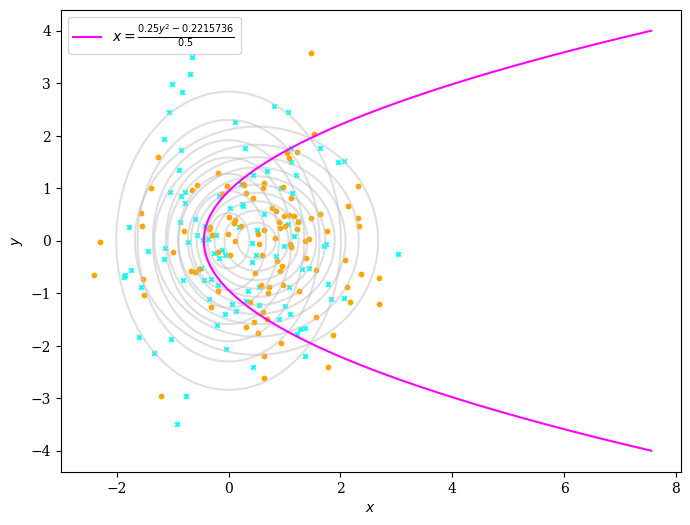

In [103]:
y = numpy.linspace(start=-4, stop=4, num=500)
x = (0.25*y**2-0.2215736)/0.5

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=\\frac{0.25y^{2}-0.2215736}{0.5}$"
)

##### Problem 1 (d)

In [104]:
mu0 = numpy.array(object=[0, 0], dtype=numpy.float32)
c0 = numpy.array(object=[[1, 0], [0, 2]], dtype=numpy.float32)
mu1 = numpy.array(object=[4, 0], dtype=numpy.float32)
c1 = numpy.array(object=[[2, 0], [0, 1]], dtype=numpy.float32)

rv0, data0 = gen_data(m=mu0, c=c0, size=100)
rv1, data1 = gen_data(m=mu1, c=c1, size=100)

W0, w0, b0 = disc_fn(mu=mu0, c=c0)
print("W0", "w0", "b0")
print(W0)
print(w0)
print(b0)

W1, w1, b1 = disc_fn(mu=mu1, c=c1)
print()
print("W1", "w1", "b1")
print(W1)
print(w1)
print(b1)

W0 w0 b0
[[-0.5   0.  ]
 [-0.   -0.25]]
[[0.]
 [0.]]
[[-1.0397208]]

W1 w1 b1
[[-0.25  0.  ]
 [-0.   -0.5 ]]
[[2.]
 [0.]]
[[-5.039721]]


\begin{align}
    g_{0}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{0}}^{\intercal}\mathbf{x}+\mathbf{w_{0}}^{\intercal}\mathbf{x}+b_{0} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.5 & 0 \\ 0 & -0.25 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 0 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -1.039721 \\
    &= -0.5x_{0}^{2}-0.25x_{1}^{2}-1.039721
\end{align}

\begin{align}    
    g_{1}(\mathbf{x}) &=
    \mathbf{x}^{\intercal}\mathbf{W_{1}}^{\intercal}\mathbf{x}+\mathbf{w_{1}}^{\intercal}\mathbf{x}+b_{1} \\
    &= \begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}^{\intercal}
    \begin{bmatrix} -0.25 & 0 \\ 0 & -0.5 \end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix} +
    \begin{bmatrix} 2 \\ 0\end{bmatrix}^{\intercal}\begin{bmatrix}x_{0} \\ x_{1}\end{bmatrix}
    -5.039721 \\
    &= -0.25x_{0}^{2}-0.5x_{1}^{2}+2x_{0}-5.039721
\end{align}

\begin{align}
    g_{0}(\mathbf{x}) &= g_{1}(\mathbf{x}) \\
    -0.5x_{0}^{2}-0.25x_{1}^{2}-1.039721 &= -0.25x_{0}^{2}-0.5x_{1}^{2}+2x_{0}-5.039721 \\
    -0.25x_{0}^{2}-2x_{0} &= -0.25x_{1}^{2}-4 \\
    0.25x_{0}^{2}+2x_{0} &= 0.25x_{1}^{2}+4 \\
    x_{0}^{2}+8x_{0} &= x_{1}^{2}+16 \\
    x_{0}^{2}+8x_{0}+16 &= x_{1}^{2}+32 \\
    (x_{0}+4)^{2} &= x_{1}^{2}+32 \\
    x_{0}+4 &= \pm\sqrt{x_{1}^{2}+32} \\
    x_{0} &= -4\pm\sqrt{x_{1}^{2}+32} \\
    x_{0} &= -4+\sqrt{x_{1}^{2}+32}
\end{align}

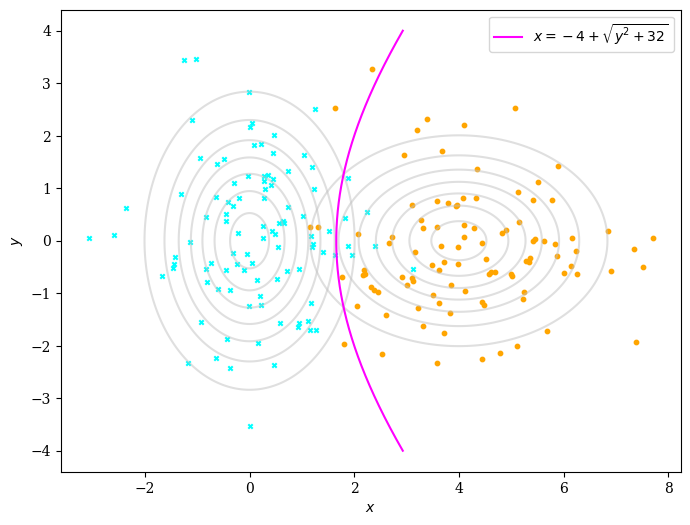

In [119]:
y = numpy.linspace(start=-4, stop=4, num=500)
x = -4+(y**2+32)**0.5

plt_decision_boundary(
    rv0=rv0,
    rv1=rv1,
    mu0=mu0,
    mu1=mu1,
    data0=data0,
    data1=data1,
    marker_size=10,
    rad=3,
    num_pts=500,
    levels=10,
    disc_x=x,
    disc_y=y,
    label="$x=-4+\sqrt{y^{2}+32}$"
)